## 1. Setup and Data Loading

In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from itertools import combinations
from collections import Counter

# Set the display format for floats to show 2 decimal places and commas
pd.options.display.float_format = '{:,.2f}'.format
# -----------------------------

# Import the Google Drive module to mount the drive
from google.colab import drive

# --- Step 1: Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully!")

# --- Step 2: Define File Path ---
file_path = '/content/drive/My Drive/Global Superstore.xls'

# --- Step 3: Load All Three Sheets ---
# The dataset is composed of three distinct tables.
# We will load each one into a separate DataFrame.

try:
    # 1. Load the 'Orders' table (the transactional core)
    df_orders = pd.read_excel(file_path, sheet_name='Orders')

    # 2. Load the 'Returns' table
    df_returns = pd.read_excel(file_path, sheet_name='Returns')

    # 3. Load the 'People' table (the dimensional table for managers)
    df_people = pd.read_excel(file_path, sheet_name='People')

    print(f"\n All three sheets loaded successfully!")
    print(f"Orders shape:  {df_orders.shape}")
    print(f"Returns shape: {df_returns.shape}")
    print(f"People shape:  {df_people.shape}")

except FileNotFoundError:
    print(f"❌ ERROR: File not found at '{file_path}'.")
    print("Please make sure the file name and location are correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully!

 All three sheets loaded successfully!
Orders shape:  (51290, 24)
Returns shape: (1173, 3)
People shape:  (13, 2)


## 2. Data Merging: Creating the Unified Data Model

In [ ]:
# --- 1. Join Orders with Returns ---
# We use a Left Join on 'Order ID' to keep all orders.
df_merged = pd.merge(
    df_orders,
    df_returns,
    on='Order ID',
    how='left'
)

# --- 2. Join the result with People ---
# We use an Inner Join on 'Region' to add the manager's name.
# The 'Region' column in the People table is the join key.
df = pd.merge(
    df_merged,
    df_people,
    on='Region',
    how='inner'
)

print("Data merged successfully!")
print(f"Final unified DataFrame shape: {df.shape}")
display(df.head())

Data merged successfully!
Final unified DataFrame shape: (46266, 27)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Returned,Market_y,Person
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Plantronics CS510 - Over-the-Head monaural Wir...,"2,309.65",7,0.00,762.18,933.57,Critical,NaN,NaN,Kelly Williams
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,"Novimex Executive Leather Armchair, Black","3,709.39",9,0.10,-288.76,923.63,Critical,Yes,APAC,Anthony Jacobs
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,"Nokia Smart Phone, with Caller ID","5,175.17",9,0.10,919.97,915.49,Medium,NaN,NaN,Anthony Jacobs
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,"Motorola Smart Phone, Cordless","2,892.51",5,0.10,-96.54,910.16,Medium,NaN,NaN,Anna Andreadi
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,"Sharp Wireless Fax, High-Speed","2,832.96",8,0.00,311.52,903.04,Critical,NaN,NaN,Deborah Brumfield


## 3. Data Cleaning and Feature Engineering

In [ ]:
import numpy as np

# --- 3.1 Data Cleaning ---

# Handle Missing Postal Codes
# We check if the column exists BEFORE trying to access it.
if 'Postal Code' in df.columns:
    print(f"Missing Postal Codes before cleaning: {df['Postal Code'].isnull().sum()}")
    df = df.drop(columns=['Postal Code'], errors='ignore')
    print("Dropped 'Postal Code' column.")
else:
    print("'Postal Code' column already dropped.")

# Convert 'Returned' column to a usable flag
# We add a check for 'Returned' before trying to convert it.
if 'Returned' in df.columns:
    df['Is_Returned'] = df['Returned'].apply(lambda x: 1 if x == 'Yes' else 0)
    # This is the corrected syntax for your drop command:
    df = df.drop(columns=['Returned', 'Market_y'], errors='ignore')
    print("Created 'Is_Returned' flag and dropped original columns.")
else:
    print("'Returned' column already processed.")


# --- 3.2 Feature Engineering (Creating Derived Metrics) ---

# Convert date columns to datetime objects
if df['Order Date'].dtype != 'datetime64[ns]':
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    print("Converted date columns to datetime.")

# 1. Create 'Order Fulfillment Time'
df['Order Fulfillment Time'] = (df['Ship Date'] - df['Order Date']).dt.days

# 2. Create 'Product Cost'
df['Product Cost'] = df['Sales'] - df['Profit']

# 3. Create 'Profit Margin'
# Use np.where to check for 0s BEFORE dividing.
df['Profit Margin'] = np.where(
    df['Sales'] == 0,       # The condition: "Is Sales equal to 0?"
    0,                      # Value if True: If Sales is 0, just make the Profit Margin 0.
    df['Profit'] / df['Sales'] # Value if False: If Sales is not 0, perform the division.
)

print("'Profit Margin' calculated safely, avoiding division by zero.")
print("Feature engineering complete!")

# --- 3.3 Final Data Check ---
print("\n--- Final DataFrame Info ---")
df.info()

Missing Postal Codes before cleaning: 36270
Dropped 'Postal Code' column.
Created 'Is_Returned' flag and dropped original columns.
'Profit Margin' calculated safely, avoiding division by zero.
Feature engineering complete!

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46266 entries, 0 to 46265
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Row ID                  46266 non-null  int64         
 1   Order ID                46266 non-null  object        
 2   Order Date              46266 non-null  datetime64[ns]
 3   Ship Date               46266 non-null  datetime64[ns]
 4   Ship Mode               46266 non-null  object        
 5   Customer ID             46266 non-null  object        
 6   Customer Name           46266 non-null  object        
 7   Segment                 46266 non-null  object        
 8   City                    46266 non

In [ ]:
# --- 3.4 Additional Feature Engineering ---

# --- Profit and Sales Per Order ---
# Calculate total profit and sales for each unique order ID
order_summary = df.groupby('Order ID').agg(
    Order_Total_Sales=('Sales', 'sum'),
    Order_Total_Profit=('Profit', 'sum')
).reset_index()

# Merge this back into the main dataframe
# Note: This adds order-level totals to each line item row
df = pd.merge(df, order_summary, on='Order ID', how='left')

print("Calculated Profit and Sales per Order.")

# --- Markup Percentage ---
# We already calculated 'Product Cost' as Sales - Profit
# Now calculate Markup Percentage = (Profit / Product Cost) * 100
# Use np.where to handle cases where Product Cost might be zero (avoid division error)
df['Markup Percentage'] = np.where(
    df['Product Cost'] == 0,
    0,  # If cost is 0, markup is 0 or undefined, let's use 0
    (df['Profit'] / df['Product Cost']) * 100
)

print("Calculated Markup Percentage.")

# --- Display new features ---
print("\n--- DataFrame with New Features (Order Totals & Markup) ---")
display(df[['Order ID', 'Sales', 'Profit', 'Product Cost', 'Order_Total_Sales', 'Order_Total_Profit', 'Markup Percentage']].head(15))

Calculated Profit and Sales per Order.
Calculated Markup Percentage.

--- DataFrame with New Features (Order Totals & Markup) ---


,Order ID,Sales,Profit,Product Cost,Order_Total_Sales,Order_Total_Profit,Markup Percentage
0,CA-2012-124891,"2,309.65",762.18,"1,547.47","3,419.87",480.64,49.25
1,IN-2013-77878,"3,709.39",-288.76,"3,998.16","4,258.79",-235.24,-7.22
2,IN-2013-71249,"5,175.17",919.97,"4,255.20","5,615.78","1,038.59",21.62
3,ES-2013-1579342,"2,892.51",-96.54,"2,989.05","2,892.51",-96.54,-3.23
4,SG-2013-4320,"2,832.96",311.52,"2,521.44","2,832.96",311.52,12.35
5,IN-2013-42360,"2,862.68",763.28,"2,099.40","3,901.85","1,030.31",36.36
6,IN-2011-81826,"1,822.08",564.84,"1,257.24","1,875.24",591.36,44.93
7,IN-2012-86369,"5,244.84",996.48,"4,248.36","5,244.84",996.48,23.46
8,CA-2014-135909,"5,083.96","1,906.48","3,177.48","5,325.88","1,938.38",60.00
9,CA-2012-116638,"4,297.64","-1,862.31","6,159.96","4,297.64","-1,862.31",-30.23


## 4. Exploratory Data Analysis (EDA)

### 4.1 Profitability Analysis


####  Question: Which product sub-categories and customer segments are the most and least profitable?

--- Profitability by Customer Segment ---


,Segment,Sales,Profit,Profit Margin
0,Consumer,"6,101,417.23","723,684.42",0.12
1,Corporate,"3,574,126.13","428,709.19",0.12
2,Home Office,"2,161,545.25","271,264.53",0.13



--- Sub-Category Performance (Sorted by Profit Margin - Efficiency) ---


,Sub-Category,Total_Sales,Total_Profit,Profit_Margin,Category
12,Paper,"234,040.06","58,320.34",0.25,Office Supplies
10,Labels,"69,310.65","14,619.64",0.21,Office Supplies
7,Envelopes,"160,324.77","28,790.28",0.18,Office Supplies
0,Accessories,"705,240.83","126,015.63",0.18,Technology
6,Copiers,"1,429,295.85","250,389.24",0.18,Technology
2,Art,"334,000.02","56,506.03",0.17,Office Supplies
3,Binders,"435,244.29","69,540.11",0.16,Office Supplies
1,Appliances,"942,794.13","138,656.54",0.15,Office Supplies
8,Fasteners,"76,891.17","10,580.33",0.14,Office Supplies
13,Phones,"1,592,685.21","213,867.28",0.13,Technology



--- Top 5 Most Profitable Sub-Categories (by Total Profit) ---


,Sub-Category,Total_Sales,Total_Profit,Profit_Margin,Category
6,Copiers,"1,429,295.85","250,389.24",0.18,Technology
13,Phones,"1,592,685.21","213,867.28",0.13,Technology
4,Bookcases,"1,374,835.33","153,986.17",0.11,Furniture
5,Chairs,"1,432,004.55","140,983.17",0.10,Furniture
1,Appliances,"942,794.13","138,656.54",0.15,Office Supplies



--- Top 5 Least Profitable / Loss-Making Sub-Categories (by Total Profit) ---


,Sub-Category,Total_Sales,Total_Profit,Profit_Margin,Category
16,Tables,"717,708.00","-66,847.64",-0.09,Furniture
8,Fasteners,"76,891.17","10,580.33",0.14,Office Supplies
10,Labels,"69,310.65","14,619.64",0.21,Office Supplies
15,Supplies,"228,936.96","21,589.78",0.09,Office Supplies
7,Envelopes,"160,324.77","28,790.28",0.18,Office Supplies


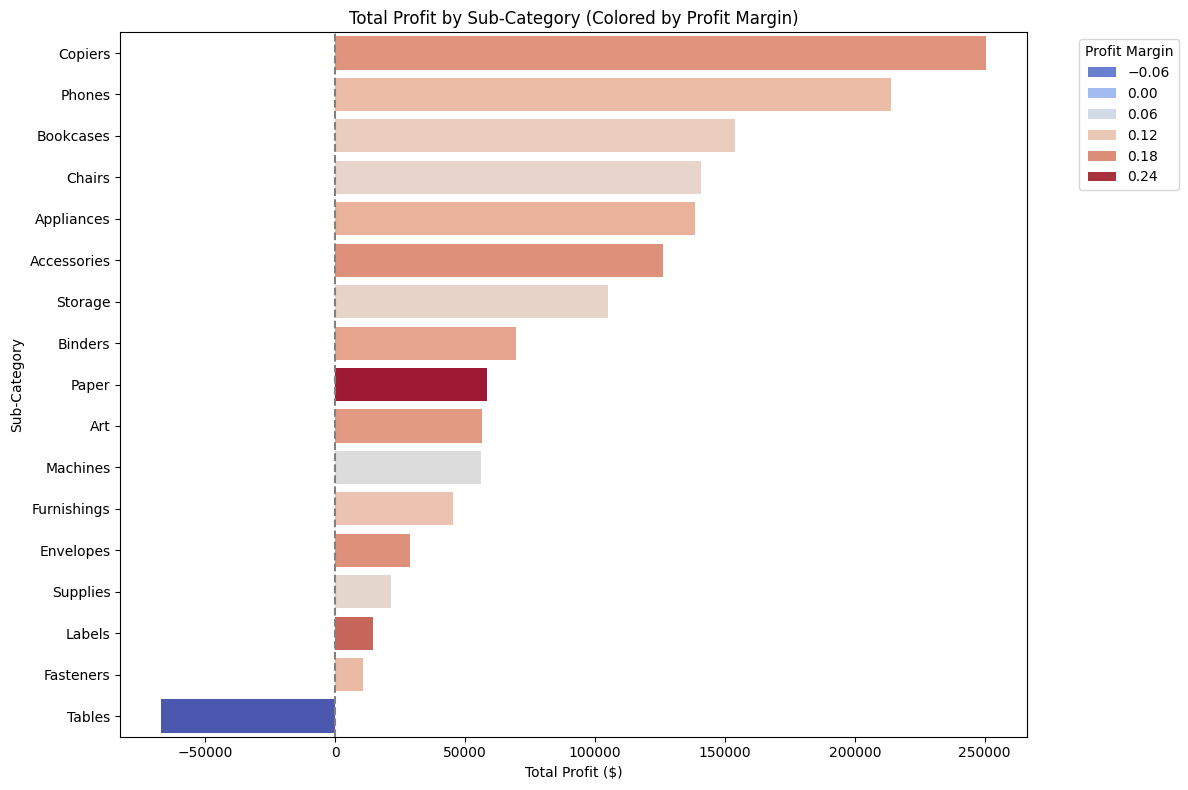

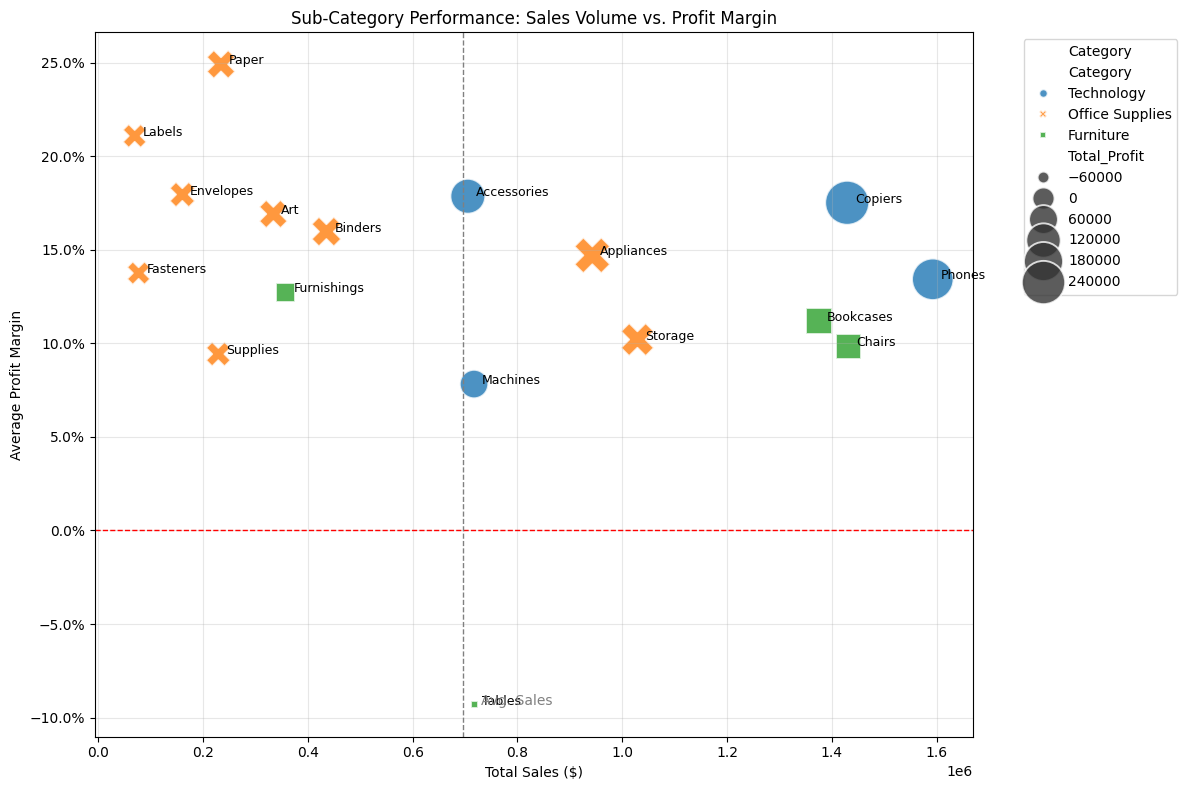

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Make sure the float formatting is set
pd.options.display.float_format = '{:,.2f}'.format

# --- 4.1 Profitability Analysis ---

# --- Profitability by Customer Segment ---
segment_profit = df.groupby('Segment')[['Sales', 'Profit']].sum().reset_index()
segment_profit['Profit Margin'] = segment_profit['Profit'] / segment_profit['Sales']

print("--- Profitability by Customer Segment ---")
display(segment_profit.sort_values(by='Profit', ascending=False))


# --- Profitability by Product Sub-Category ---
# Create the new, more detailed dataframe
sub_category_analysis = df.groupby('Sub-Category').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index()

# Calculate Profit Margin for each sub-category
sub_category_analysis['Profit_Margin'] = np.where(
    sub_category_analysis['Total_Sales'] == 0, 0,
    sub_category_analysis['Total_Profit'] / sub_category_analysis['Total_Sales']
)

# Add the parent 'Category' (Furniture, Tech, etc.)
category_map = df[['Category', 'Sub-Category']].drop_duplicates()
sub_category_analysis = pd.merge(sub_category_analysis, category_map, on='Sub-Category')

# --- Display more insightful tables ---
print("\n--- Sub-Category Performance (Sorted by Profit Margin - Efficiency) ---")
# This table shows which items are most/least EFFICIENT
display(sub_category_analysis.sort_values(by='Profit_Margin', ascending=False))

print("\n--- Top 5 Most Profitable Sub-Categories (by Total Profit) ---")
# NOW this table will show 'Profit_Margin'
display(sub_category_analysis.sort_values(by='Total_Profit', ascending=False).head())

print("\n--- Top 5 Least Profitable / Loss-Making Sub-Categories (by Total Profit) ---")
# AND this table will show 'Profit_Margin'
display(sub_category_analysis.sort_values(by='Total_Profit', ascending=True).head())


# --- Bar Plot ---
plt.figure(figsize=(12, 8))
sns.barplot(
    data=sub_category_analysis.sort_values(by='Total_Profit', ascending=False),
    x='Total_Profit',
    y='Sub-Category',
    hue='Profit_Margin',
    palette='coolwarm',
    dodge=False
)
plt.legend(title='Profit Margin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Total Profit by Sub-Category (Colored by Profit Margin)')
plt.xlabel('Total Profit ($)')
plt.ylabel('Sub-Category')
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()


# --- Profitability Quadrant Analysis (Sales vs. Margin Scatter Plot) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=sub_category_analysis,
    x='Total_Sales',
    y='Profit_Margin',
    size='Total_Profit',
    hue='Category',
    style='Category',
    sizes=(50, 1000),
    alpha=0.8
)

for i in range(sub_category_analysis.shape[0]):
    plt.text(x=sub_category_analysis['Total_Sales'][i] + 15000,
             y=sub_category_analysis['Profit_Margin'][i],
             s=sub_category_analysis['Sub-Category'][i],
             fontdict=dict(color='black',size=9))

plt.title('Sub-Category Performance: Sales Volume vs. Profit Margin')
plt.xlabel('Total Sales ($)')
plt.ylabel('Average Profit Margin')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.axhline(0, color='red', linestyle='--', lw=1)
plt.axvline(sub_category_analysis['Total_Sales'].mean(), color='grey', linestyle='--', lw=1)
plt.text(sub_category_analysis['Total_Sales'].mean() * 1.05,
         sub_category_analysis['Profit_Margin'].min(),
         'Avg. Sales', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Category')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Discounting Strategy


#### Question: How does the discount rate affect profit margin?

--- Discount Impact on Average Profit Margin (Detailed) ---


,Discount,Average_Profit_Margin,Total_Sales
0,0.00,0.27,"6,314,515.21"
1,0.00,0.23,"261,395.62"
2,0.07,0.18,"121,616.85"
3,0.10,0.16,"1,579,606.37"
4,0.15,0.09,"283,879.85"
5,0.15,0.13,"22,149.99"
6,0.17,0.11,"247,399.20"
7,0.20,0.15,"1,204,184.61"
8,0.20,-0.00,"16,215.65"
9,0.25,0.02,"88,055.35"



--- Binned Discount Impact (for Visualization) ---


,Discount_Bin,Average_Profit_Margin,Total_Sales
0,0-10%,0.25,"8,277,134.06"
1,10-20%,0.14,"1,757,613.66"
2,20-30%,-0.04,"382,554.69"
3,30-40%,-0.25,"698,790.63"
4,40-50%,-0.45,"474,688.31"
5,50%+,-1.26,"246,307.26"


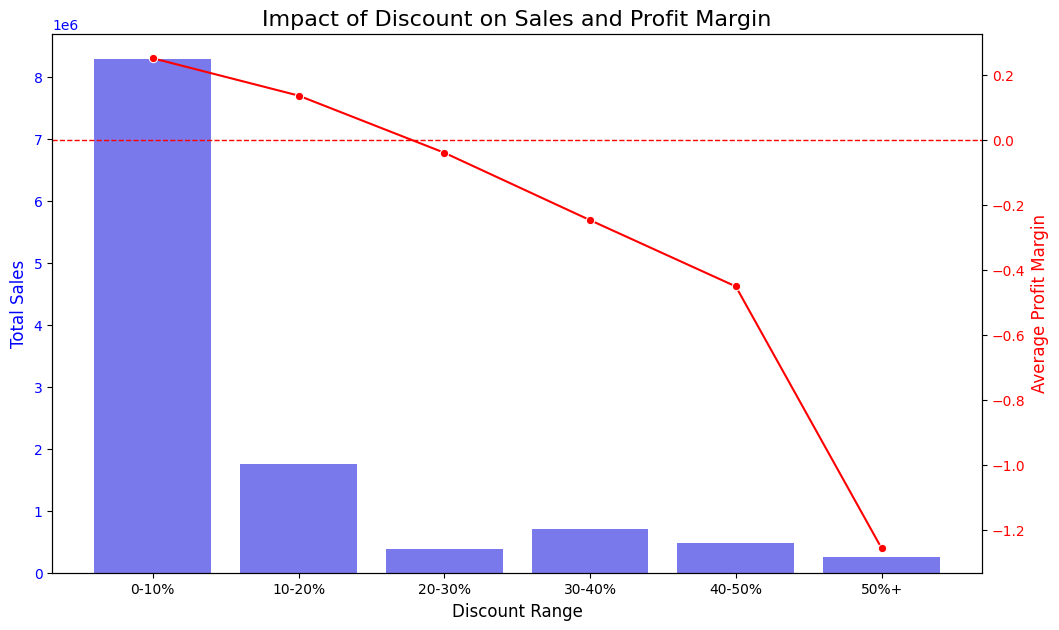

In [ ]:
discount_analysis = df.groupby('Discount').agg(
    Average_Profit_Margin=('Profit Margin', 'mean'),
    Total_Sales=('Sales', 'sum')
).reset_index()

print("--- Discount Impact on Average Profit Margin (Detailed) ---")
display(discount_analysis)

# --- Cleaner Binned Visualization ---
# Now, we will create the binned data just for a cleaner plot.

# 1. Define the bins and labels for our discount groups
bins = [-0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50%+']

# 2. Create a 'Discount_Bin' column
# We use pd.cut to segment the data.
if 'Discount_Bin' not in df.columns:
    df['Discount_Bin'] = pd.cut(df['Discount'], bins=bins, labels=labels, right=True)

# 3. Group by these new bins to get clean summary data
discount_analysis_binned = df.groupby('Discount_Bin', observed=True).agg(
    Average_Profit_Margin=('Profit Margin', 'mean'),
    Total_Sales=('Sales', 'sum')
).reset_index()

print("\n--- Binned Discount Impact (for Visualization) ---")
display(discount_analysis_binned)

# 4. Visualize the Binned Data
fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Impact of Discount on Sales and Profit Margin', fontsize=16)

# Bar plot for Total Sales (left y-axis)
sns.barplot(data=discount_analysis_binned, x='Discount_Bin', y='Total_Sales', ax=ax1, color='b', alpha=0.6)
ax1.set_ylabel('Total Sales', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Discount Range', fontsize=12)

# Line plot for Average Profit Margin (right y-axis)
ax2 = ax1.twinx() # Create a second y-axis
sns.lineplot(data=discount_analysis_binned, x='Discount_Bin', y='Average_Profit_Margin', ax=ax2, color='r', marker='o')
# ----------------------------------

ax2.set_ylabel('Average Profit Margin', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

# Add a dashed red line at 0 to show the break-even point
ax2.axhline(0, color='red', linestyle='--', lw=1)

plt.show()

### 4.3 Logistics & Customer Satisfaction


#### Question: What is the relationship between Ship Mode, fulfillment time, and return rates?

In [ ]:
# --- Calculate Overall Return Rate ---
total_orders = df['Order ID'].nunique()
returned_orders = df[df['Is_Returned'] == 1]['Order ID'].nunique()
overall_return_rate = (returned_orders / total_orders) * 100
print(f"Overall Order Return Rate: {overall_return_rate:.2f}%")

# --- Analysis by Ship Mode ---
# We use our 'Is_Returned' flag and 'Order Fulfillment Time' metric.
logistics_analysis = df.groupby('Ship Mode').agg(
    Average_Fulfillment_Time_Days=('Order Fulfillment Time', 'mean'),
    Return_Rate=('Is_Returned', 'mean')
).reset_index()

# Convert Return_Rate to percentage
logistics_analysis['Return_Rate'] = logistics_analysis['Return_Rate'] * 100

print("\n--- Logistics Analysis by Ship Mode ---")
display(logistics_analysis.sort_values(by='Average_Fulfillment_Time_Days'))

# --- Cost of Returns Analysis ---
# Calculate total sales and profit for returned line items
returns_financials = df[df['Is_Returned'] == 1].agg(
    Total_Sales_Returned=('Sales', 'sum'),
    Total_Profit_Lost_on_Returns=('Profit', 'sum') # Note: Profit includes losses already
).reset_index()

# Calculate return financials by Sub-Category
returns_by_subcat = df[df['Is_Returned'] == 1].groupby('Sub-Category').agg(
    Returned_Sales=('Sales', 'sum'),
    Returned_Profit_Impact=('Profit', 'sum')
).reset_index().sort_values(by='Returned_Sales', ascending=False)


print("\n--- Financial Impact of Returns ---")
display(returns_financials)
print("\n--- Returns Impact by Sub-Category (Top 5 by Sales Returned) ---")
display(returns_by_subcat.head())

# --- Shipping Cost Analysis ---
# Calculate Shipping Cost as a Percentage of Sales
df['Shipping_Cost_Pct_Sales'] = (df['Shipping Cost'] / df['Sales']) * 100
# Handle cases where Sales is 0 to avoid errors/infinity
df['Shipping_Cost_Pct_Sales'] = df['Shipping_Cost_Pct_Sales'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Analyze by Sub-Category
shipping_cost_analysis = df.groupby('Sub-Category').agg(
    Avg_Shipping_Cost_Pct=('Shipping_Cost_Pct_Sales', 'mean'),
    Total_Shipping_Cost=('Shipping Cost', 'sum')
).reset_index().sort_values(by='Avg_Shipping_Cost_Pct', ascending=False)

print("\n--- Shipping Cost Analysis by Sub-Category (Sorted by Avg % of Sales) ---")
display(shipping_cost_analysis.head(10)) # Show top 10 highest shipping cost %

# Compare Shipping Cost vs Profit by Sub-Category
profit_vs_shipping = sub_category_analysis[['Sub-Category', 'Total_Profit']].merge(
    shipping_cost_analysis[['Sub-Category', 'Total_Shipping_Cost']],
    on='Sub-Category'
)
profit_vs_shipping['Profit_After_Shipping'] = profit_vs_shipping['Total_Profit'] - profit_vs_shipping['Total_Shipping_Cost']

print("\n--- Sub-Category Profit vs. Shipping Cost ---")
display(profit_vs_shipping.sort_values(by='Profit_After_Shipping').head()) # Show where shipping hurts most

Overall Order Return Rate: 5.19%

--- Logistics Analysis by Ship Mode ---


,Ship Mode,Average_Fulfillment_Time_Days,Return_Rate
1,Same Day,0.04,7.21
0,First Class,2.19,7.23
2,Second Class,3.23,6.81
3,Standard Class,5.00,6.33



--- Financial Impact of Returns ---


,index,Sales,Profit
0,Total_Sales_Returned,"819,768.38",NaN
1,Total_Profit_Lost_on_Returns,NaN,"117,998.82"



--- Returns Impact by Sub-Category (Top 5 by Sales Returned) ---


,Sub-Category,Returned_Sales,Returned_Profit_Impact
6,Copiers,"110,465.33","23,963.39"
13,Phones,"100,538.62","15,417.38"
4,Bookcases,"92,079.60","13,116.29"
5,Chairs,"90,195.42","8,816.08"
1,Appliances,"87,807.94","18,581.85"



--- Shipping Cost Analysis by Sub-Category (Sorted by Avg % of Sales) ---


,Sub-Category,Avg_Shipping_Cost_Pct,Total_Shipping_Cost
1,Appliances,11.24,"102,010.35"
0,Accessories,11.04,"79,022.47"
2,Art,11.03,"36,971.74"
12,Paper,11.01,"25,524.03"
3,Binders,10.99,"45,522.41"
4,Bookcases,10.95,"146,061.08"
10,Labels,10.91,"7,557.23"
7,Envelopes,10.89,"17,297.67"
8,Fasteners,10.89,"8,382.19"
6,Copiers,10.86,"150,806.41"



--- Sub-Category Profit vs. Shipping Cost ---


,Sub-Category,Total_Profit,Total_Shipping_Cost,Profit_After_Shipping
16,Tables,"-66,847.64","74,522.31","-141,369.95"
11,Machines,"56,126.05","72,163.98","-16,037.93"
5,Chairs,"140,983.17","156,161.99","-15,178.83"
14,Storage,"105,008.97","109,707.94","-4,698.97"
15,Supplies,"21,589.78","23,233.89","-1,644.11"


### 4.4 Regional Performance (by Manager)


#### Question: Which regional managers are overseeing the top-performing regions based on profit margin and sales?

--- Enhanced Managerial Performance ---


,Person,Total_Sales,Total_Profit,Total_Orders,Regions,Avg_Profit_Margin,Sales_Per_Order,Profit_Per_Order
9,Nicole Hansen,"66,928.17","17,817.39",201,[Canada],0.27,332.98,88.64
11,Shirley Daniels,"848,309.78","165,578.42",1150,[North Asia],0.20,737.66,143.98
10,Nora Preis,"752,826.57","132,480.19",1026,[Central Asia],0.18,733.75,129.12
6,Jack Lebron,"1,248,700.61","194,719.56",2356,[North],0.16,530.01,82.65
8,Matt Collister,"725,457.82","108,418.45",1611,[West],0.15,450.32,67.30
7,Kelly Williams,"678,781.24","91,522.78",1401,[East],0.13,484.50,65.33
4,Deborah Brumfield,"783,773.21","88,871.63",2232,[Africa],0.11,351.15,39.82
1,Anna Andreadi,"2,822,515.51","311,381.19",5249,[Central],0.11,537.72,59.32
2,Anthony Jacobs,"1,100,184.61","120,089.11",1744,[Oceania],0.11,630.84,68.86
5,Giulietta Dortch,"324,280.86","34,571.32",855,[Caribbean],0.11,379.28,40.43


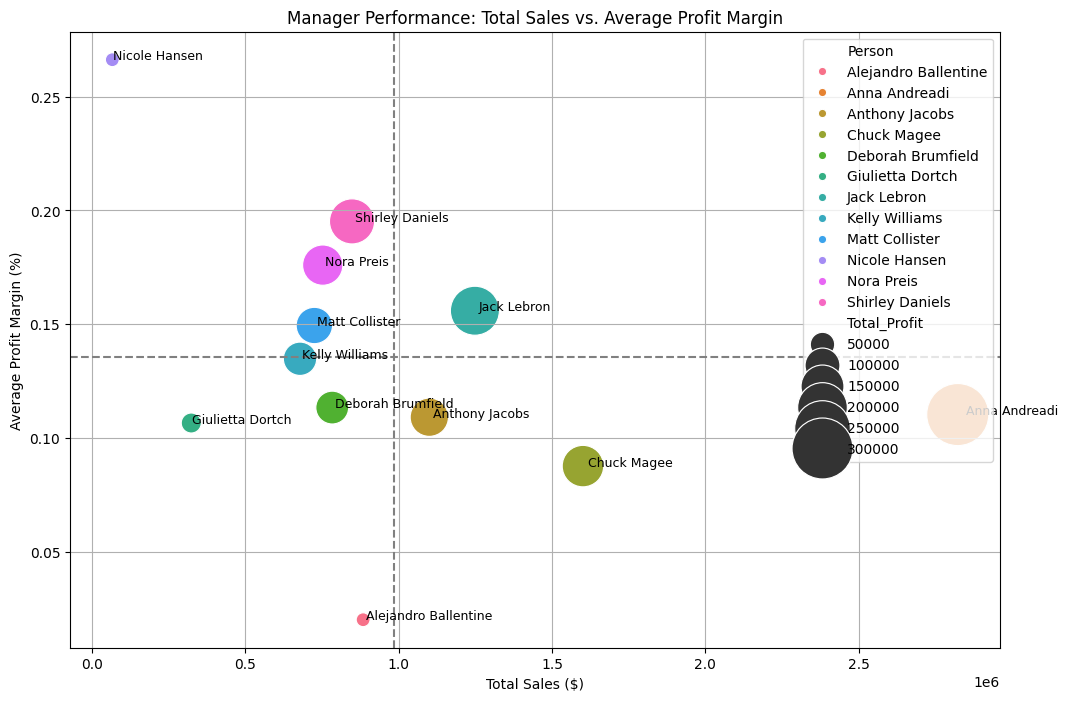

In [ ]:
# --- 4.4 Regional Performance (by Manager) ---

# Aggregate core metrics by Manager
manager_performance = df.groupby('Person').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Orders=('Order ID', 'nunique'), # Count unique orders
    Regions=('Region', 'unique')
).reset_index()

# Calculate Efficiency Metrics
manager_performance['Avg_Profit_Margin'] = (manager_performance['Total_Profit'] / manager_performance['Total_Sales'])
manager_performance['Sales_Per_Order'] = manager_performance['Total_Sales'] / manager_performance['Total_Orders']
manager_performance['Profit_Per_Order'] = manager_performance['Total_Profit'] / manager_performance['Total_Orders']

print("--- Enhanced Managerial Performance ---")
# Sort by Profit Margin to see efficiency
display(manager_performance.sort_values(by='Avg_Profit_Margin', ascending=False))


# --- Visualize Manager Performance (Sales vs. Margin) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=manager_performance,
    x='Total_Sales',
    y='Avg_Profit_Margin',
    size='Total_Profit', # Bubble size by total profit contribution
    hue='Person',       # Color by manager
    sizes=(100, 2000),   # Control bubble size
    legend='brief'      # Keep legend manageable
)

# Add labels for each manager
for i in range(manager_performance.shape[0]):
    plt.text(x=manager_performance['Total_Sales'][i] * 1.01, # Offset slightly
             y=manager_performance['Avg_Profit_Margin'][i],
             s=manager_performance['Person'][i],
             fontdict=dict(color='black',size=9))

plt.title('Manager Performance: Total Sales vs. Average Profit Margin')
plt.xlabel('Total Sales ($)')
plt.ylabel('Average Profit Margin (%)')
# Add lines for average sales and average margin
plt.axhline(manager_performance['Avg_Profit_Margin'].mean(), color='grey', linestyle='--')
plt.axvline(manager_performance['Total_Sales'].mean(), color='grey', linestyle='--')
plt.grid(True)
plt.show()

### 4.5 Temporal Trends (Seasonality)


#### Question: Are there significant seasonal patterns in sales and profit over time?

--- Monthly Sales and Profit (Last 12 Months) ---


/tmp/ipython-input-3537523262.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trends = df_time.resample('M')[['Sales', 'Profit']].sum()


,Sales,Profit
Order Date,,
2014-01-31,"224,501.88","28,596.64"
2014-02-28,"159,686.08","14,990.41"
2014-03-31,"242,948.18","35,753.85"
2014-04-30,"230,640.34","23,551.45"
2014-05-31,"265,898.33","33,618.95"
2014-06-30,"369,447.70","41,675.88"
2014-07-31,"238,037.77","26,647.76"
2014-08-31,"418,006.28","49,014.99"
2014-09-30,"444,883.24","65,548.60"


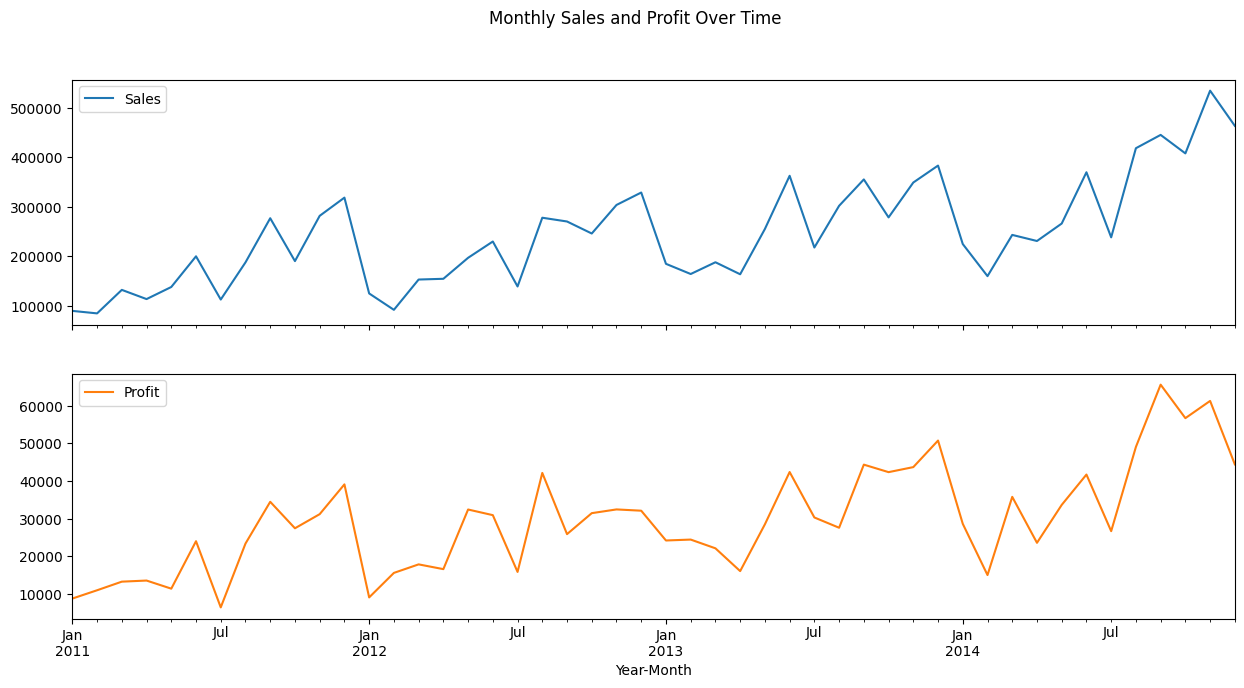

In [ ]:
# We need to set 'Order Date' as the index to resample by time.
df_time = df.set_index('Order Date')

# Resample the data by month ('M') and sum the Sales and Profit
monthly_trends = df_time.resample('M')[['Sales', 'Profit']].sum()

print("--- Monthly Sales and Profit (Last 12 Months) ---")
display(monthly_trends.tail(12))

# Plot the time series data
monthly_trends.plot(
    figsize=(15, 7),
    title='Monthly Sales and Profit Over Time',
    subplots=True, # Create separate plots for Sales and Profit
    layout=(2, 1) # Arrange them in 2 rows, 1 column
)
plt.xlabel('Year-Month')
plt.show()

### ## 4.6 Customer Segmentation Analysis (RFM) 🧑‍💼

**Objective:** Segment customers based on their purchase behavior (Recency, Frequency, Monetary Value) to identify high-value, loyal, and at-risk groups.

--- Raw RFM Metrics ---


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,9,19,"13,747.41"
1,AA-10375,7,23,"5,884.20"
2,AA-10480,126,20,"17,695.59"
3,AA-10645,29,36,"15,343.89"
4,AA-315,154,1,10.74



--- RFM Scores ---


,Customer ID,Recency,Frequency,Monetary,RFM_Score
0,AA-10315,9,19,"13,747.41",534
1,AA-10375,7,23,"5,884.20",543
2,AA-10480,126,20,"17,695.59",235
3,AA-10645,29,36,"15,343.89",455
4,AA-315,154,1,10.74,211



--- RFM Segments ---


,Customer ID,RFM_Score,Segment
0,AA-10315,534,Loyal Customers
1,AA-10375,543,Champions
2,AA-10480,235,Needs Attention
3,AA-10645,455,Champions
4,AA-315,211,Lost Customers



--- RFM Segment Summary Statistics ---


,Segment,Count,Avg_Recency,Avg_Frequency,Avg_Monetary
1,Champions,428,13.72,28.21,"15,077.12"
0,"At Risk (High Freq, Not Recent)",54,92.69,26.56,"14,271.78"
3,Loyal Customers,352,33.60,20.31,"10,448.56"
4,Needs Attention,179,132.06,6.18,"2,313.72"
5,Potential Loyalists (New),79,15.90,3.14,"1,131.37"
2,Lost Customers,466,415.92,2.57,926.99


/tmp/ipython-input-2532645103.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


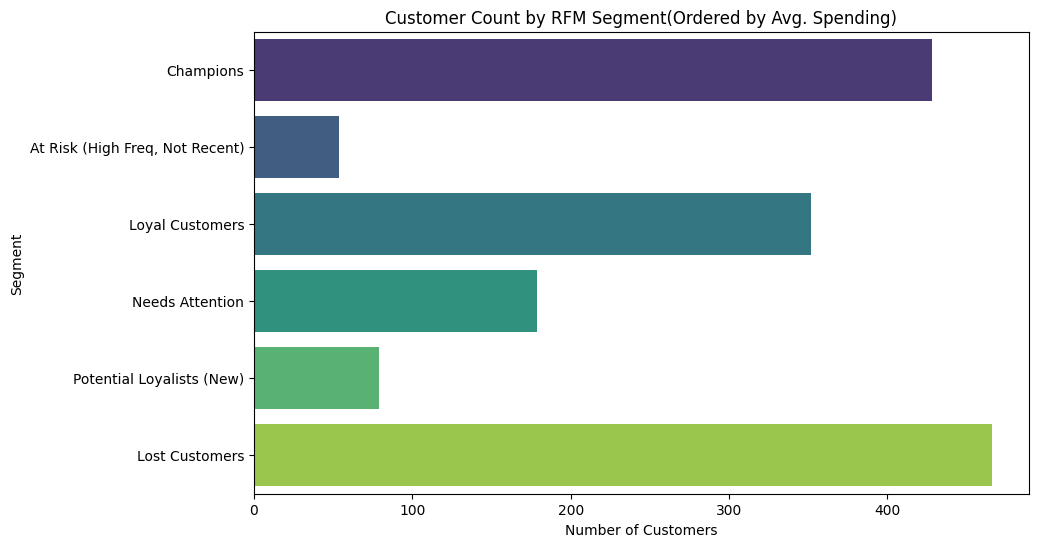

In [ ]:
# --- Calculate RFM Metrics ---

# 1. Recency: Days since last purchase
# Find the most recent date in the dataset to use as a reference point
snapshot_date = df['Order Date'].max() + dt.timedelta(days=1)
# Group by customer and find the most recent purchase date, then calculate days difference
recency_df = df.groupby('Customer ID')['Order Date'].max().reset_index()
recency_df['Recency'] = (snapshot_date - recency_df['Order Date']).dt.days
recency_df = recency_df[['Customer ID', 'Recency']]

# 2. Frequency: Total number of unique orders
frequency_df = df.groupby('Customer ID')['Order ID'].nunique().reset_index()
frequency_df.columns = ['Customer ID', 'Frequency']

# 3. Monetary: Total sales value
monetary_df = df.groupby('Customer ID')['Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID', 'Monetary']

# --- Combine RFM metrics ---
rfm_df = pd.merge(recency_df, frequency_df, on='Customer ID')
rfm_df = pd.merge(rfm_df, monetary_df, on='Customer ID')

print("--- Raw RFM Metrics ---")
display(rfm_df.head())

# --- Calculate RFM Scores ---
# Divide each metric into quantiles (e.g., 5 groups, 1-5 score)
# Lower Recency is better (more recent), Higher Frequency/Monetary is better
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1]) # 5 is most recent
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]) # 5 is most frequent
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5]) # 5 is highest value

# Combine scores into a single RFM score string
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

print("\n--- RFM Scores ---")
display(rfm_df[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']].head())

# --- Create RFM Segments (Example) ---
# Define segments based on score ranges (adjust rules as needed)
def assign_segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
         return 'Potential Loyalists (New)'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return 'At Risk (High Freq, Not Recent)'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Lost Customers'
    else:
        return 'Needs Attention' # Catch-all for other combinations

# Convert scores to numeric for comparison
rfm_df['R_Score'] = rfm_df['R_Score'].astype(int)
rfm_df['F_Score'] = rfm_df['F_Score'].astype(int)
rfm_df['M_Score'] = rfm_df['M_Score'].astype(int)

rfm_df['Segment'] = rfm_df.apply(assign_segment, axis=1)

print("\n--- RFM Segments ---")
display(rfm_df[['Customer ID', 'RFM_Score', 'Segment']].head())

# --- Analyze Segment Statistics ---
segment_summary = rfm_df.groupby('Segment').agg(
    Count=('Customer ID', 'count'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index().sort_values(by='Avg_Monetary', ascending=False)

print("\n--- RFM Segment Summary Statistics ---")
display(segment_summary)

# --- Visualize Segment Distribution ---
plt.figure(figsize=(10, 6))
sns.countplot(
    data=rfm_df,
    y='Segment',
    order=segment_summary['Segment'], # Keep ordering by Avg Monetary
    palette='viridis' #<-- CHOOSE YOUR PALETTE (e.g., 'viridis', 'magma', 'Set2', 'tab10')
)

plt.title('Customer Count by RFM Segment(Ordered by Avg. Spending)')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()

### ## 4.7 Basic Market Basket Analysis

**Objective:** Identify which product sub-categories are frequently purchased together in the same order.

In [12]:
# --- Find Co-purchased Item Pairs ---

# Group by Order ID and get a list of unique sub-categories in each order
order_items = df.groupby('Order ID')['Sub-Category'].unique().reset_index()

# Filter out orders with only one type of sub-category
order_items = order_items[order_items['Sub-Category'].apply(len) > 1]

# Generate all pairs of sub-categories within each order
all_pairs = []
for items in order_items['Sub-Category']:
    # Sort items to ensure ('A', 'B') is the same as ('B', 'A')
    sorted_items = sorted(items)
    # Create combinations of size 2
    pairs = list(combinations(sorted_items, 2))
    all_pairs.extend(pairs)

# Count the frequency of each pair
pair_counts = Counter(all_pairs)

# Convert counts to a DataFrame for easier analysis
pairs_df = pd.DataFrame(pair_counts.most_common(), columns=['Pair', 'Frequency'])

print("--- Most Frequent Co-purchased Sub-Category Pairs ---")
display(pairs_df.head(10)) # Show top 10 pairs

# --- Analyze Profitability of Top Pairs (Example) ---
# Let's check the profitability of the #1 most frequent pair
top_pair = pairs_df['Pair'][0]
print(f"\n--- Analyzing orders containing the top pair: {top_pair} ---")

# Find orders containing both items of the top pair
orders_with_top_pair = df[
    df['Order ID'].isin(
        order_items[order_items['Sub-Category'].apply(lambda x: all(item in x for item in top_pair))]['Order ID']
    )
]

# Calculate the average profit margin ONLY for orders containing this specific pair
avg_margin_top_pair_orders = orders_with_top_pair['Profit Margin'].mean() * 100
print(f"Average Profit Margin for orders containing {top_pair}: {avg_margin_top_pair_orders:.2f}%")

# Compare to the overall average profit margin
overall_avg_margin = df['Profit Margin'].mean() * 100
print(f"Overall Average Profit Margin: {overall_avg_margin:.2f}%")

# Check if unprofitable items are part of frequent pairs
unprofitable_subs = sub_category_analysis[sub_category_analysis['Total_Profit'] < 0]['Sub-Category'].tolist()
print(f"\nUnprofitable Sub-categories: {unprofitable_subs}")

frequent_pairs_with_losses = pairs_df[
    pairs_df['Pair'].apply(lambda pair: any(item in unprofitable_subs for item in pair))
]
print("\n--- Frequent Pairs Containing Unprofitable Items ---")
display(frequent_pairs_with_losses.head())

--- Most Frequent Co-purchased Sub-Category Pairs ---


,Pair,Frequency
0,"(Binders, Storage)",818
1,"(Art, Binders)",761
2,"(Art, Storage)",697
3,"(Binders, Paper)",627
4,"(Binders, Phones)",580
5,"(Binders, Furnishings)",544
6,"(Binders, Chairs)",538
7,"(Accessories, Binders)",527
8,"(Phones, Storage)",475
9,"(Paper, Storage)",464



--- Analyzing orders containing the top pair: ('Binders', 'Storage') ---
Average Profit Margin for orders containing ('Binders', 'Storage'): 5.37%
Overall Average Profit Margin: 6.79%

Unprofitable Sub-categories: ['Tables']

--- Frequent Pairs Containing Unprofitable Items ---


,Pair,Frequency
106,"(Binders, Tables)",142
115,"(Storage, Tables)",124
119,"(Art, Tables)",106
122,"(Phones, Tables)",98
123,"(Accessories, Tables)",97


## Concise Conclusion
This analysis of the Global Superstore dataset (2011-2014) successfully identified key drivers of profitability and areas for improvement. By merging order, return, and regional data and engineering crucial metrics like profit margin and fulfillment time, we uncovered significant insights:

1. Profit Drivers: Technology products (especially Copiers & Phones) and the 'Consumer' segment are major profit contributors.

2. Key Issues: The 'Tables' sub-category consistently generates losses despite high sales volume, largely due to high costs and discounts. Discounts exceeding 25% generally lead to negative profit margins across most categories. High shipping costs significantly erode profits for bulky items like 'Machines' and 'Chairs'.

3. Customer Insights: RFM segmentation revealed distinct customer groups, including valuable 'Champions' and a large 'At Risk' segment needing re-engagement.

4. Regional Performance: Manager efficiency varies significantly, with some regions (like Canada) showing high margins despite low volume, while others (like Southeast Asia) exhibit low margins despite high volume.

These findings highlight opportunities to optimize pricing/discount strategies, improve product mix profitability, enhance customer retention efforts, and address regional performance disparities.